In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
from utils import *
import pickle

mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq_fixed/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    df_extra_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_qcd_extra_inneronly_features.h5")
                    df_QCD = pd.concat([df_QCD, df_extra_QCD], axis=0)
                    
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        (np.array([ts[i][order2[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts[i][order1[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts2[i][order2[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2,
                                        (np.array([ts2[i][order1[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
    # with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "wb") as f:
    #     pickle.dump(x_array, f)

In [77]:
# with open("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", "wb") as f:
#         pickle.dump(x_array, f)

In [6]:
qq = "qq"
qqq = "qqq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
def load_data(filename, noise_dims):

    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for q in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,q, False] = x_array_read[mycounter]

                if noise_dims and qq == "qq":
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", noise_dims = 0)
#x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", noise_dims = 0)

In [28]:
np.shape(x[0,0, qq, True])

(121352, 16)

In [5]:
np.shape(x[0,0, qq, False])

(734210, 6)

In [7]:
np.shape(x[0,0, qqq, False])

(734210, 6)

In [82]:
x_data_qq = []
y_data_qq = []
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qq = np.concatenate([x_data_qq,x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([y_data_qq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [11]:
x_data_qqq = []
y_data_qqq = []
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qqq']:
            qq = "qqq"
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qqq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qqq = np.concatenate([x_data_qqq,x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([y_data_qqq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [83]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra", x_data_qq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra", y_data_qq)

In [9]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_fixed", x_data_qqq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_fixed", y_data_qqq)

In [11]:
x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra.npy")
y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra.npy")

In [54]:
# x_data_qq = np.load("x_parametrized_data_qq_fixed.npy")
# y_data_qq = np.load("y_parametrized_data_qq_fixed.npy")

In [12]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qq, y_data_qq, test_size=0.5, random_state = 42)

In [85]:
len(Y_train_qq)

57750203

In [12]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5, random_state = 42)

In [19]:
X_train_qqq

array([[-1.01357652, -1.73295289,  1.20862549, ...,  1.01502877,
         2.        ,  1.5       ],
       [-0.82867141,  1.29552367, -0.08583506, ..., -2.22494426,
         3.5       ,  3.5       ],
       [-1.13499651,  1.07107216, -0.36806473, ...,  0.89796848,
         1.        ,  6.        ],
       ...,
       [-1.45647626, -1.72667151,  1.86582934, ...,  1.60819248,
         5.5       ,  0.5       ],
       [-1.22105544,  1.56863124,  1.07320472, ...,  1.3650016 ,
         3.5       ,  5.5       ],
       [ 0.94213325, -1.13824551, -1.30352825, ..., -2.13668104,
         5.        ,  6.        ]])

In [11]:
# x_data_qqq = np.load("x_data_qqq.npy")
# y_data_qqq = np.load("y_data_qqq.npy")

In [383]:
np.shape(x_data_qq)

(27249420, 8)

In [9]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from wandb.keras import WandbCallback

pscratch_dir = "/pscratch/sd/g/gupsingh/"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 128,
    "layer_3_neurons": 64,
    "output_neurons": 1,
    "activation": "relu",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh',
           mode = 'online',
           config=config)

config = wandb.config
run_name = wandb.run.name

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def train_parametrized(X_train, Y_train, X_val, Y_val, config, return_history=False):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train)[1], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
        
    if return_history:
        return model_parametrized, history_parametrized
    else:
        return model_parametrized

model_parametrized, history_parametrized = train_parametrized(X_train_qq, Y_train_qq, X_val_qq, Y_val_qq, config, return_history=True)

wandb.finish()

#model_parametrized.save(pscratch_dir + run_name + qq + "notebook")
#model_parametrized.save(pscratch_dir+"normal")

Epoch 1/2
56380/56397 [============================>.] - ETA: 0s - loss: 0.0720 - accuracy: 0.9743

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best)... Done. 0.0s


56397/56397 [==============================] - 216s 4ms/step - loss: 0.0720 - accuracy: 0.9743 - val_loss: 0.0689 - val_accuracy: 0.9753
Epoch 2/2
56387/56397 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9751

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240229_203935-cdftttvg/files/model-best)... Done. 0.0s


56397/56397 [==============================] - 209s 4ms/step - loss: 0.0693 - accuracy: 0.9751 - val_loss: 0.0683 - val_accuracy: 0.9755


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁█
epoch,▁█
loss,█▁
val_accuracy,▁█
val_loss,█▁
accuracy,0.97507
best_epoch,1
best_val_loss,0.06828
epoch,1
loss,0.06932
val_accuracy,0.97547


In [19]:
# num_epochs = len(history_parametrized.history["loss"])
# send_slack_message(f"Notebook Parametrized Training Finished - Epochs: {num_epochs}")

In [5]:
#Diagonistic Plot
plt.figure()
plt.plot(history_parametrized.history['loss'], label='Training Loss')
plt.plot(history_parametrized.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
img_path = "plots/parametrized_trainingloss.png"
plt.savefig(img_path)
plt.legend()
plt.show()

from utils import send_slack_plot
send_slack_plot(img_path)

In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94709
best_epoch,41
best_val_loss,0.13607
epoch,41
loss,0.1365
val_accuracy,0.94731


In [15]:
#model_qq.save(pscratch_dir + "model_fixed")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


In [8]:
preds_mm_list = []
tuple_rates_dedicated_benchmark_extra = {}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        if (m1 == 5 and m2 == 1) or (m1 == 3 and m2 == 3) or (m1 == 1 and m2 == 1) or (m1 == 3 and m2 == 4.5):
            x_data_mm = np.concatenate([x[0,0, qq, False],x[m1,m2, qq, False]])
            y_data_mm = np.concatenate([np.zeros(len(x[0,0, qq, False])),np.ones(len(x[m1,m2, qq, False]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_data_mm, y_data_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(256, input_dim=6, activation='relu'))
            #model.add(BatchNormalization())
            model.add(Dense(128, activation='relu'))
            #model.add(BatchNormalization())
            model.add(Dense(64, activation='relu'))
            #model.add(BatchNormalization())
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_benchmark_extra[tuple((m1, m2))] = [fpr_mm, tpr_mm]
            
np.save("tuple_rates_dedicated_benchmark_extra.npy", tuple_rates_dedicated_benchmark_extra)

Epoch 1/1000


2024-03-08 18:42:18.301657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79099 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-03-08 18:42:20.095121: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f16a44e3cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 18:42:20.095137: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-08 18:42:20.103315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-08 18:42:20.134331: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1709952140.218865  434923 device_compiler.h:186] Compiled cluster using XLA!  Thi

396/396 [==============================] - 3s 3ms/step - loss: 0.1318 - accuracy: 0.9520 - val_loss: 0.0919 - val_accuracy: 0.9663
Epoch 2/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0856 - accuracy: 0.9685 - val_loss: 0.0815 - val_accuracy: 0.9697
Epoch 3/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0788 - accuracy: 0.9705 - val_loss: 0.0791 - val_accuracy: 0.9706
Epoch 4/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0766 - accuracy: 0.9712 - val_loss: 0.0764 - val_accuracy: 0.9715
Epoch 5/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0762 - accuracy: 0.9713 - val_loss: 0.0755 - val_accuracy: 0.9717
Epoch 6/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0757 - accuracy: 0.9715 - val_loss: 0.0770 - val_accuracy: 0.9709
Epoch 7/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0756 - accuracy: 0.9714 - val_loss: 0.0765 - val_accuracy: 0.9712
Epoch

/tmp/ipykernel_484454/1937793855.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  validation_plot(m1,m2)


809/809 [==============================] - 2s 2ms/step


/tmp/ipykernel_484454/1937793855.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/tmp/ipykernel_484454/1937793855.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  validation_plot(m1,m2)


809/809 [==============================] - 2s 2ms/step


/tmp/ipykernel_484454/1937793855.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/tmp/ipykernel_484454/1937793855.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  validation_plot(m1,m2)


809/809 [==============================] - 2s 2ms/step


/tmp/ipykernel_484454/1937793855.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/tmp/ipykernel_484454/1937793855.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  validation_plot(m1,m2)


809/809 [==============================] - 2s 2ms/step


/tmp/ipykernel_484454/1937793855.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/tmp/ipykernel_484454/1937793855.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  validation_plot(m1,m2)


809/809 [==============================] - 2s 2ms/step


/tmp/ipykernel_484454/1937793855.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


Plot sent successfully: None


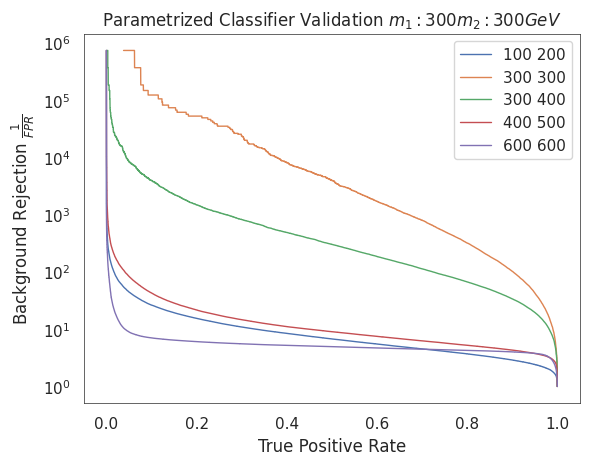

In [41]:
import seaborn as sns
from utils import send_slack_plot 
#epsilon = 1e-4
m1 = 1
m2 = 1

#takes parametrized data corresponding to m1,m2 and replaces it with wrong masses
#then evaluates the data on trained parametrized model
def validation_plot(m1, m2):
    m1_masses_to_try = [1, 3, 3, 4, 6]
    m2_masses_to_try = [2, 3, 4, 5, 6]
    for m1_try, m2_try in zip(m1_masses_to_try, m2_masses_to_try):
        parametrized_data = x_data_qq[np.prod(x_data_qq[:,6:8]==[m1,m2],axis=1)==1]
        parametrized_data[:,6:8]= np.c_[np.ones(len(parametrized_data)) * m1_try, np.ones(len(parametrized_data)) * m2_try]
        preds_parametrized = model_qq.predict(parametrized_data,batch_size=1000)
        fpr_all, tpr_all, _ = metrics.roc_curve(y_data_qq[np.prod(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], preds_parametrized)
        plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
        plt.legend()
        plt.title(f"Parametrized Classifier Validation $m_{1}: {m1*100}  m_{2}: {m2*100} GeV$")
        plt.xlabel("True Positive Rate")
        plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
        sns.set(style="white")
        plt.gca().spines['top'].set_linewidth(0.5)
        plt.gca().spines['right'].set_linewidth(0.5)
        plt.gca().spines['bottom'].set_linewidth(0.5)
        plt.gca().spines['left'].set_linewidth(0.5)
        plt.yscale("log")
    img_path = f"plots/validationplot{float(m1)}{float(m2)}.png"
    #plt.savefig(img_path, dpi=450, bbox_inches='tight')
    send_slack_plot(img_path)
    
validation_plot(m1,m2)

In [13]:
model_name = "decent-sun-87qq"
model_qq = tf.keras.models.load_model(f"/pscratch/sd/g/gupsingh/{model_name}")
def eval_parametrized(model_parametrized):
    preds_parametrized_list = []
    tuples_rates_parametrized = {}
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            if (m1 == 3 and m2 == 3) or (m1 == 5 and m2 == 1) or (m1 == 1 and m2 == 1) or (m1 == 3 and m2 == 4.5):
                preds_parametrized = model_parametrized.predict(x_data_qq[np.prod(x_data_qq[:,6:8]==[m1,m2],axis=1)==1],batch_size=1000)
                fpr_parametrized, tpr_parametrized, _ = metrics.roc_curve(y_data_qq[np.prod(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], preds_parametrized)

                preds_parametrized_list.append(preds_parametrized)
                tuples_rates_parametrized[tuple((m1, m2))] = [fpr_parametrized, tpr_parametrized]
    np.save(f"tuples_rates_parametrized_{model_name}.npy", tuples_rates_parametrized)
    return tuples_rates_parametrized

eval_parametrized(model_qq)

793/793 [==============================] - 1s 710us/step


{(1,
  1): [array([0.        , 0.        , 0.        , ..., 0.99487204, 0.99556394,
         1.        ]), array([0.00000000e+00, 3.92808977e-05, 5.23745303e-05, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (3,
  3): [array([0.        , 0.        , 0.        , ..., 0.99846229, 0.9992686 ,
         1.        ]), array([0.00000000e+00, 1.34278655e-05, 4.02835965e-05, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (3,
  4.5): [array([0.        , 0.        , 0.        , ..., 0.99874695, 0.99945111,
         1.        ]), array([0.00000000e+00, 1.38454296e-05, 5.53817185e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (5,
  1): [array([0.        , 0.        , 0.        , ..., 0.99131856, 0.9960529 ,
         1.        ]), array([0.00000000e+00, 1.71892189e-05, 1.89081408e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])]}

/tmp/ipykernel_431996/1749727627.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
/tmp/ipykernel_431996/1749727627.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')


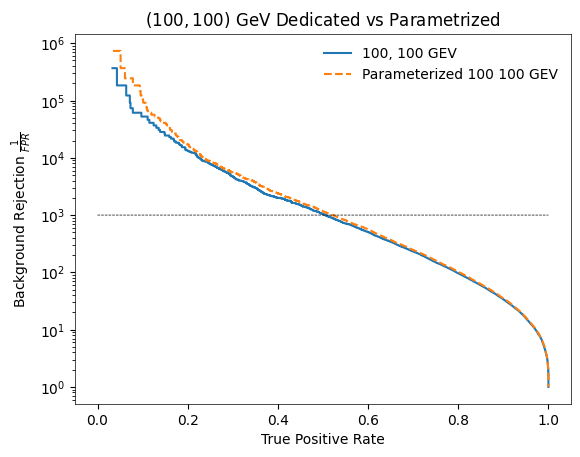

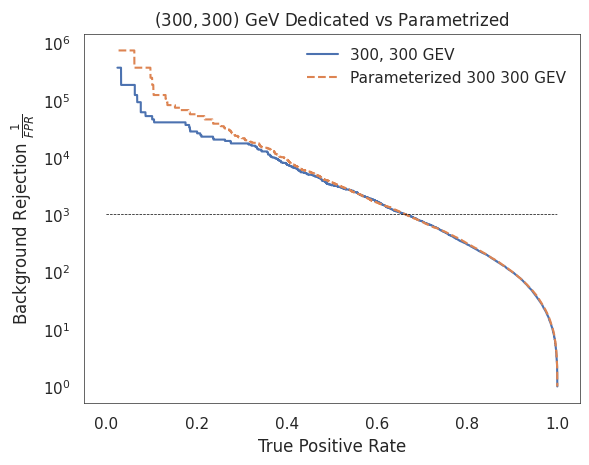

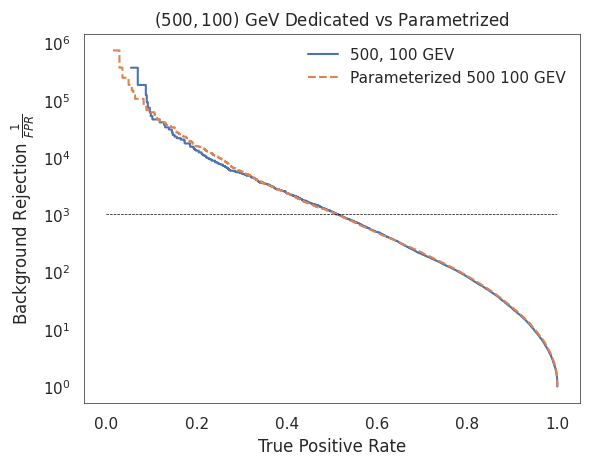

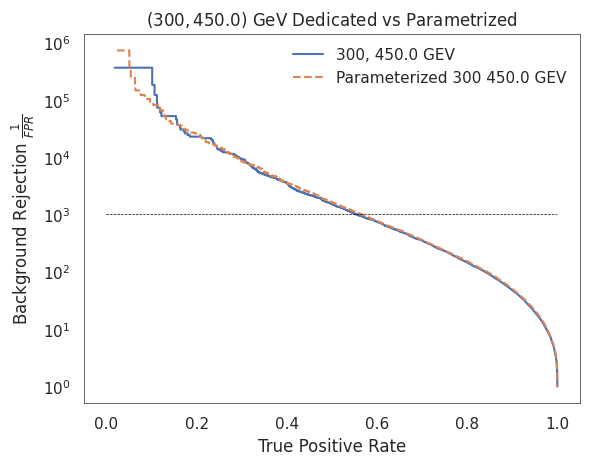

In [15]:
import seaborn as sns
model_name = "decent-sun-87qq"
def plot_comparison(m1, m2):
    fpr_cut = 1e-3
    tuple_rates_parametrized = np.load(f"tuples_rates_parametrized_{model_name}.npy", allow_pickle = True).item()
    tuple_rates_dedicated = np.load("tuple_rates_dedicated_benchmark_extra.npy", allow_pickle = True).item()
    #tuple_rates_dedicated = np.load("tuple_rates_dedicated_fixed.npy", allow_pickle = True).item()
    
    fpr = tuple_rates_parametrized[(m1,m2)][0]
    tpr = tuple_rates_parametrized[(m1,m2)][1]
    
    index = np.argmin(np.abs(np.array(fpr) - fpr_cut))

    fpr_cut = fpr[index]
    tpr_cut = tpr[index]

    plt.figure()
    plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
    plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')
    #draw line at fpr cut
    plt.plot(tuple_rates_parametrized[(m1, m2)][1], [1e3] * len(tuple_rates_parametrized[(m1, m2)][1]), linestyle = "--", color = "black", linewidth = 0.5)
    plt.yscale("log")
    plt.legend(frameon=False)
    plt.xlabel("True Positive Rate")
    plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
    plt.title(f"$({m1*100}, {m2*100})$ GeV Dedicated vs Parametrized")
    sns.set(style="white")
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.show()

plot_comparison(1, 1)
plot_comparison(3, 3)
plot_comparison(5, 1)
plot_comparison(3, 4.5)

In [13]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/eager-rain-75")

In [14]:
qq = 'qq'
noise = False

# initial_learning_rate = 0.07
# final_learning_rate = 0.07
# decay_steps = 10

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps,
#     decay_rate=tf.math.exp(tf.math.log(final_learning_rate / initial_learning_rate) / decay_steps),
#     staircase=False
# )

weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4
tuple_rates_semiweak = {}
scoreLossdict = {}

w1, w2 = np.round(np.random.uniform(0.5, 6.0, size=2),3)
#w1, w2 = 3, 3
w1, w2 = 4.695, 2.16
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
sigspace = np.logspace(-3,-1,10)
test = []
for sigfrac in sigspace:

    #sigfrac = 0.1
    print(w1, w2, sigfrac)

    for l in model_qq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_regularizer=MinMaxRegularizer())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2),kernel_regularizer=MinMaxRegularizer())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-4))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+LLR_xs)
    model_semiweak = Model(inputs = inputs, outputs = ws)
    model_semiweak.compile(loss='BCE', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05))

    m1 = 3
    m2 = 3

    test_background = int(1/2 * len(x[0,0, qq, False]) + 1)
    train_reference = int(1/4 *len(x[0,0, qq, False]))
    train_data = int(1/4 * len(x[0,0, qq, False]))
    test_signal = int(1/2*len(x[m1,m2, qq, False]))

    #fixed signal portion
    N = int(1/4 *len(x[0,0, qq, False]))
    signal = x[m1,m2, qq, False][test_signal:test_signal+int(sigfrac*N)]
    x_data_ = np.concatenate([x[0,0, qq, False][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    myhistory = model_semiweak.fit(X_train_[:,0:6], Y_train_,
                                         epochs=1000,validation_data=(X_val_[:,0:6], Y_val_),
                                         batch_size=1024, callbacks = [es], verbose = 0)

    print(m1,m2,model_semiweak.trainable_weights[0].numpy()[0][0],model_semiweak.trainable_weights[1].numpy()[0][0])
    weight_list1+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

    scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    max_sic1.append(np.max(tpr/np.sqrt(fpr + epsilon)))

    scoreLossdict[(sigfrac)] = ((min(myhistory.history["loss"])), scores)
    
    top_items = sorted(scoreLossdict.values())[:3]
    lowest_loss_scores = [x[1] for x in top_items]
    fpr, tpr, _ = metrics.roc_curve(y, np.median(lowest_loss_scores, axis = 0))
    tuple_rates_semiweak[(sigfrac)] = (fpr, tpr)
    test.append(np.max(tpr/np.sqrt(fpr + epsilon)))
    print(test)

4.695 2.16 0.001
3 3 4.368758 1.4253086
395/395 [==============================] - 1s 943us/step
[1.5608065727252407]
4.695 2.16 0.0016681005372000592
3 3 2.8068254 2.7339642
395/395 [==============================] - 1s 975us/step
[1.5608065727252407, 20.30637494077549]
4.695 2.16 0.0027825594022071257
3 3 2.763015 3.0535932
395/395 [==============================] - 1s 958us/step
[1.5608065727252407, 20.30637494077549, 23.30212752709882]
4.695 2.16 0.004641588833612777
3 3 2.8921325 2.9419844
395/395 [==============================] - 0s 918us/step
[1.5608065727252407, 20.30637494077549, 23.30212752709882, 27.092377828794465]
4.695 2.16 0.007742636826811269
3 3 2.934702 3.014082
395/395 [==============================] - 1s 950us/step
[1.5608065727252407, 20.30637494077549, 23.30212752709882, 27.092377828794465, 27.507394596315255]
4.695 2.16 0.01291549665014884
3 3 2.9103165 2.965978
395/395 [==============================] - 0s 920us/step
[1.5608065727252407, 20.30637494077549, 23.

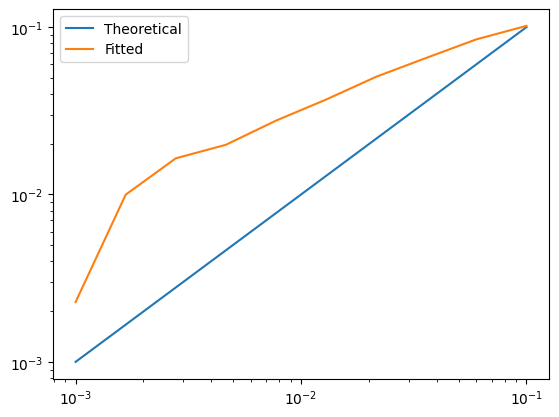

In [15]:
sigspace = np.logspace(-3, -1, 10)
plt.plot(sigspace, sigspace, label = "Theoretical")
plt.plot(sigspace, np.exp(weight_list3), label = "Fitted")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

(0.0, 700.0)

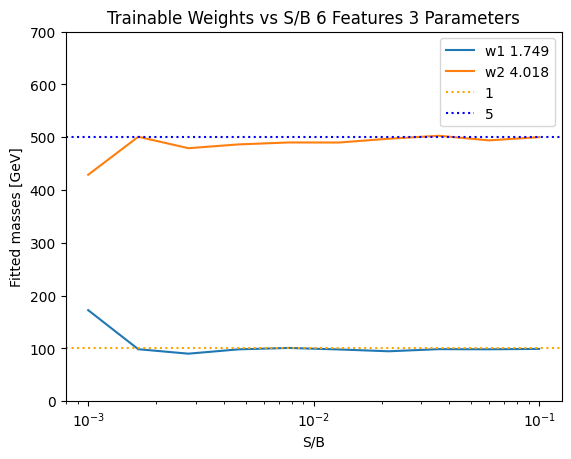

In [20]:
plt.plot(sigspace,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sigspace,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [24]:
#dedicated training on single mass pair
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
def train_supervised(feature_dims, m1, m2, fpr_cut = 1e-4):
    epsilon = 1e-4
    x_data_full = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
    y_data_full = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
    X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5, random_state = 42)

    model_dedicated = Sequential()
    model_dedicated.add(Dense(256, input_dim=feature_dims, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(64, activation='relu'))
    model_dedicated.add(Dense(1, activation='sigmoid'))
    model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

    history_fullySupervised = model_dedicated.fit(X_train_full, Y_train_full, epochs=1000,validation_data=(X_val_full, Y_val_full),batch_size=1024, verbose = 0, callbacks = [es])
    preds = model_dedicated.predict(X_val_full,batch_size=1024)
    fpr, tpr, _ = metrics.roc_curve(Y_val_full, preds)
    adjusted_fpr = np.maximum(fpr, fpr_cut)
    maxsic = np.max(tpr / np.sqrt(adjusted_fpr + epsilon))
    return maxsic

#CWOLA comparison
def compileCWOLA(feature_dims, m1, m2):
    model_cwola = Sequential()
    model_cwola.add(Dense(256, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
    return model_cwola

class MinMaxRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self):
        self.min_val = 0.5
        self.max_val = 6
        self.l = 1

    def __call__(self, x):
        x_under = tf.cast(tf.less(x, self.min_val), dtype=tf.float32)
        x_over  = tf.cast(tf.greater(x, self.max_val), dtype=tf.float32)
        under_penalty = (tf.exp(self.min_val - x) - 1)
        over_penalty = (tf.exp(x - self.max_val) - 1)
        penalty = self.l * tf.math.reduce_sum(((x_under * under_penalty) + (x_over * over_penalty)))
        return penalty

    def get_config(self):
        return {'l': float(self.l),
              'min_val': float(self.min_val),
              'max_val': float(self.max_val)}

from tensorflow.keras.constraints import Constraint
class WeightConstraint(Constraint):
    def __init__(self, min_value=0.5, max_value=6):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value}

# initial_learning_rate = 0.05
# final_learning_rate = 0.01
# decay_epochs = 50

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_rate=(final_learning_rate / initial_learning_rate) ** (1.0 / decay_epochs),
#     decay_steps=1,
#     staircase=True)

#SemiWeak Model
def compileSemiWeakly(sigfrac, model, feature_dims, params, m1, m2, w1, w2):
    
    for l in model.layers:
        l.trainable=False
        
    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_regularizer=MinMaxRegularizer())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_regularizer=MinMaxRegularizer())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-2))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    epsilon = 1e-4
    #physics prior
    hidden_layer_1 = model(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)

    if params == 2:
        LLR_xs = 1.+sigfrac*LLR - sigfrac
    elif params == 3:
        LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    else:
        print("Choose 2 or 3 parameters")
    ws = LLR_xs / (1.+LLR_xs)

    SemiWeakModel = Model(inputs = inputs, outputs = ws)
    SemiWeakModel.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05, clipvalue=0.0001, clipnorm=0.0001))
    return SemiWeakModel

def compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2):
    #freeze both two pronged and three pronged prior models
    for l in model_qq.layers:
        l.trainable=False

    for l in model_qqq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs_hold4 = tf.keras.Input(shape=(1,))
    simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
    model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    hidden_layer_13 = model_qqq(inputs2)
    LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
    LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
    
    if parameters == 2:
        LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
    if parameters == 4:
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0]) - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
    SemiWeak3Prong = Model(inputs = inputs, outputs = ws)
    SemiWeak3Prong.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05, clipvalue=0.0001, clipnorm=0.0001))
    return SemiWeak3Prong

In [6]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/deep-forest-83qq")
model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/breathless-flower-61qqq")

model_qqq._name = "model_qqq"
for l in model_qqq.layers:
    l._name = f"{l.name}_model_qqq"

In [8]:
decay = "qqq"
noise = False
sigmoid = lambda x: 1. / (1. + np.exp(-x))
feature_dims = 6
parameters = 4
    
msic1 = []
weight_list1 = []
weight_list2 = []
weight_list3 = []
weight_list4 = []

epsilon = 1e-4

sigspace = np.logspace(-3, -1, 10)
test = []
tuple_rates_semiweak3 = {}
scoreLossdict = {}

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)
w1,w2 = 0.728, 4.781

for sigfrac in sigspace:
    print(sigfrac, w1, w2)
    
    m1 = 3
    m2 = 3

    semiweak_3prong = compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)
    
    test_background = int(1/2 * len(x[0,0, decay, noise])+1)
    train_reference = int(1/4 *len(x[0,0, decay, noise]))
    train_data = int(1/4 * len(x[0,0, decay, noise]))
    test_signal = int(1/2*len(x[m1,m2, decay, noise]))

    #randomize signal events
    random_test_signal_length = random.randint(0, test_signal - 1)
    N = int(1/4 * (len(x[0,0, decay, noise])))
    signal = x[m1, m2, decay, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

    #mix both samples
    # signal_mixed = np.concatenate([x[m1, m2, decay][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
    # background_mixed = np.concatenate([x[0,0,decay][:int(test_background/2)], x[0,0,qq][:int(test_background/2)]])

    x_data_ = np.concatenate([x[0,0,decay, noise][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    # x_data_mixed = np.concatenate([background_mixed,signal_mixed])
    # y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    history_semiweak3Prong = semiweak_3prong.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
    scores = semiweak_3prong.predict(np.concatenate([x[0,0, decay, noise][0:test_background],x[m1,m2, decay, noise][0:test_signal]]),batch_size=1024)
    
    scoreLossdict[(sigfrac)] = ((min(history_semiweak3Prong.history["loss"])), scores)
    
    top_items = sorted(scoreLossdict.values())[:3]
    lowest_loss_scores = [x[1] for x in top_items]
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    fpr, tpr, _ = metrics.roc_curve(y, np.median(lowest_loss_scores, axis = 0))
    tuple_rates_semiweak3[(sigfrac)] = (fpr, tpr)
    test.append(np.max(tpr/np.sqrt(fpr + epsilon)))
    
    print(m1,m2,semiweak_3prong.trainable_weights[0].numpy()[0][0],semiweak_3prong.trainable_weights[1].numpy()[0][0])

    weight_list1+=[semiweak_3prong.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[semiweak_3prong.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[semiweak_3prong.trainable_weights[2].numpy()[0][0]]
    weight_list4+=[semiweak_3prong.trainable_weights[3].numpy()[0][0]]

0.001 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 0.5 5.3552756
0.0016681005372000592 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 0.581752 4.9439316
0.0027825594022071257 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 1.089532 5.8397837
0.004641588833612777 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 0.5206433 5.928417
0.007742636826811269 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 0.5 5.9758143
0.01291549665014884 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 0.62197757 3.7139857
0.021544346900318832 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 2.9425492 3.0313153
0.03593813663804626 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 2.8950922 3.1776993
0.05994842503189409 0.728 4.781
396/396 [==============================] - 1s 1ms/step
3 3 2.894816 2.9911122
0.1 0.728 4.781
396/396

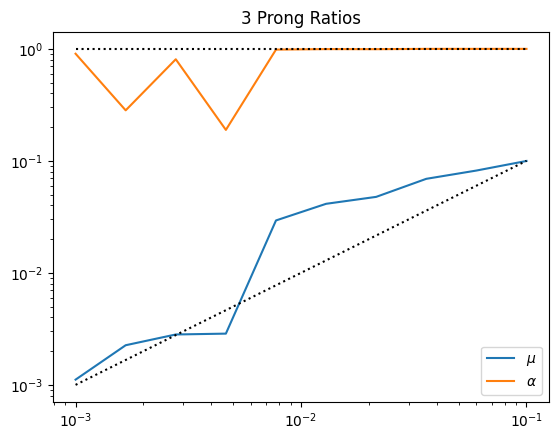

In [18]:
plt.plot(sigspace,np.exp(weight_list3),label=r"$\mu$")
plt.plot(sigspace,sigmoid(np.array(weight_list4)),label=r"$\alpha$")
plt.plot(sigspace,sigspace,ls=":",color="black")
plt.plot(sigspace, [sigmoid(weight_list4[-1])] * 10, ls = ":", color = "black")
plt.title("3 Prong Ratios")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

(0.0, 700.0)

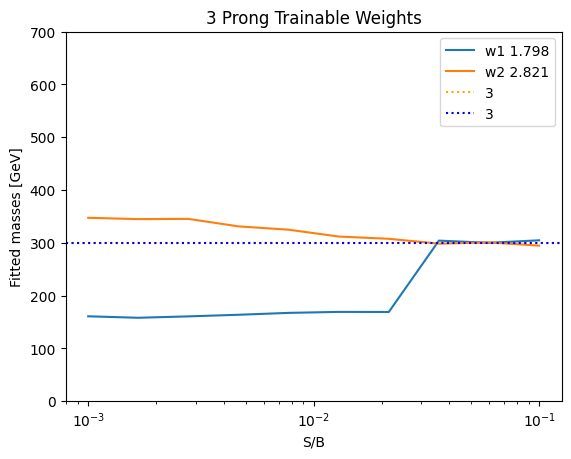

In [58]:
plt.plot(sigspace,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sigspace,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("3 Prong Trainable Weights")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [17]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.
from utils import get_stuck_weights

noise = False
epsilon = 1e-4
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/deep-forest-83qq")
def train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = "qq"):
    maxsicandstd1 = {}
    maxsicandstd2 = {}
    msic1_runs = []
    msic2_runs = []
    std1_runs = []
    std2_runs = []
    score1_injections_raw_runs = []
    score2_injections_raw_runs = []
    weight_list1_runs = []
    weight_list2_runs = []
    weight_list3_runs = []
    weight_list4_runs = []
    initial_weights_runs = []
    tuple_rates_semiweak = {}
    tuple_rates_weak = {}

    qq = decay
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    sigspace = np.logspace(-3, -1, 10)
    for sigfrac in sigspace:
        print(f"At {sigfrac} for decay {decay}")

        initial_weights = []

        msic1_median = []
        msic2 = []
        score1_injections = []
        score2_injections = []
        weight_list1_injections = []
        weight_list2_injections = []
        weight_list3_injections = []
        weight_list4_injections = []

        print(f"---------------{sigfrac}---------------")

        # N ~ Poission(M) injected events
        for injection in range(injections):
            print(f"Injecting N = {injections - injection} more times, currently on: N = {injection}")

            #randomized signal
            random_test_signal_length = random.randint(0, test_signal - 1)
            N = int(1/4 * (len(x[0,0, qq, noise])))
            signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

            score1_kruns = []
            weight_list1_kruns = []
            weight_list2_kruns = []
            weight_list3_kruns = []
            weight_list4_kruns = []
            scoreLossdict = {}

            print(f"Ensembling {m_initializations} for Signal Fraction : {sigfrac}")
            for k in range(m_initializations):

                w1 = round(random.uniform(0.5, 6),3)
                w2 = round(random.uniform(0.5, 6),3)
                initial_weights.append((w1, w2))

                print(f"Initialization: {w1} {w2}")

                if decay == "qq":
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)

                if decay == "qqq":
                    model_semiweak = compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)

                test_background = int(1/2 * len(x[0,0, qq, noise])+1)
                train_reference = int(1/4 *len(x[0,0, qq, noise]))
                train_data = int(1/4 * len(x[0,0, qq, noise]))
                test_signal = int(1/2*len(x[m1,m2, qq, noise]))

                x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                history_semiweak = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=1000,
                                                          validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

                print(f"m1: {m1}",f"m2: {m2}", f"w1: {model_semiweak.trainable_weights[0].numpy()[0][0]}", f"w2: {model_semiweak.trainable_weights[1].numpy()[0][0]}")

                weight_list1_kruns+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
                weight_list2_kruns+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
                weight_list3_kruns+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

                if decay == "qqq":
                    weight_list4_kruns+=[model_semiweak.trainable_weights[3].numpy()[0][0]]

                scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
                #per-event probability
                score1_kruns.append(scores)
                scoreLossdict[(min(history_semiweak.history["loss"]))] = scores
                #scoreLossdict[(sigfrac, injections, k)] = ((min(history_semiweak.history["loss"])), scores)

            #kruns finished
            weight_list1_injections.append(weight_list1_kruns)
            weight_list2_injections.append(weight_list2_kruns)
            weight_list3_injections.append(weight_list3_kruns)
            if decay == "qqq":
                weight_list4_injections.append(weight_list4_kruns)

            #now average over the k classifiers runs
            y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])

            #get the lowest scores from dictionary of losses and scores
            # top_items = sorted(scoreLossdict.values())[:3]
            # lowest_loss_scores = [x[1] for x in top_items]
            # fpr, tpr, _ = metrics.roc_curve(y, np.median(lowest_loss_scores, axis = 0))
            # tuple_rates_semiweak[(sigfrac, injection)] = (fpr, tpr)
            top_items = sorted(scoreLossdict.items())[:3]
            lowest_losses = [x[0] for x in top_items]
            top_scores = [scoreLossdict[loss] for loss in lowest_losses]
            fpr, tpr, _ = metrics.roc_curve(y, np.median(top_scores, axis = 0))
            tuple_rates_semiweak[(sigfrac, injection)] = (fpr, tpr)

            epsilon = 1e-4

            msic1_kmedian = np.max(tpr/np.sqrt(fpr+epsilon))
            score1_injections.append(score1_kruns)
            msic1_median.append(msic1_kmedian)
            print(f" --- msic1_median on injection {injection}: {msic1_kmedian} ---")

            #weakly supervised only inject no k classifiers (out of mass initialization loop) no averaging to be done yet
            model_CWOLA = compileCWOLA(feature_dims, m1, m2)
            history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=1000,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

            scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            score2_injections.append(scores2)

            y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
            msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
            tuple_rates_weak[(sigfrac, injection)] = (fpr2, tpr2)

        msic1_runs.append(np.median(msic1_median))
        print(f" --- msic1_runs for signal fraction {sigfrac}: {np.median(msic1_median)} ---")
        std1_runs.append(np.std(msic1_median))
        print(f" --- msic1_runs_std for signal fraction {sigfrac}: {np.std(msic1_median)} ---")

        print(f" --- msic2_runs for signal fraction {sigfrac}: {np.median(msic2)} ---")
        std2_runs.append(np.std(msic2))
        print(f" --- msic2_runs_std for signal fraction {sigfrac}: {np.std(msic2)} ---")
        msic2_runs.append(np.median(msic2))

        score1_injections_raw_runs.append(score1_injections)
        score2_injections_raw_runs.append(score2_injections)
        weight_list1_runs.append(weight_list1_injections)
        weight_list2_runs.append(weight_list2_injections)
        weight_list3_runs.append(weight_list3_injections)
        if decay == "qqq":
            weight_list4_runs.append(weight_list4_injections)

        # maxsicandstd1[sigfrac] = (np.median(msic1_median), np.std(msic1_median))
        # maxsicandstd2[sigfrac] = (np.median(msic2), np.std(msic2))
        
        if len(x[0,0, qq, noise]) > 121352:
            extra = True
            
        extra_str = "_extra" if extra else ""
        # np.save(f"data/maxsicandstd1_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd1)
        # np.save(f"data/maxsicandstd2_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd2)

    stuck_weights = get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1_runs, weight_list2_runs, decay)
    np.save(f"data/stuck_weights_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", stuck_weights)
    np.save(f"data/tuplerates_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", tuple_rates_semiweak)
    np.save(f"data/tuplerates2_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", tuple_rates_weak)
    np.save(f"data//scoreLossdict{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", scoreLossdict)

    # np.save(f"data/msic1_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd1)
    # np.save(f"data/msic2_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd2)
    # np.save(f"data/std1_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", std1_runs)
    # np.save(f"data/std2_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", std2_runs)
    np.save(f"data/weight_list1_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list1_runs)
    np.save(f"data/weight_list2_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list2_runs)
    np.save(f"data/weight_list3_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list3_runs)

    np.save(f"data/score1_injections_raw_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", score1_injections_raw_runs)
    np.save(f"data/score2_injections_raw_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", score2_injections_raw_runs)
    if decay == "qqq":
        np.save(f"data/weight_list4_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list4_runs)
    np.save(f"data/initial_weights_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", initial_weights_runs)

In [10]:
!ls $PSCRATCH

4Feature		     model_qq_youthful-disco
astral-shadow-39	     neat-tree-47
avid-river-83qq		     S4_Invariant.hdf5
breathless-flower-61qqq      S6_Invariant.hdf5
copper-serenity-64qq	     silvery-star-24
dashing-bee-82		     swept-wildflower-68qq
decent-sound-44		     swift-night-80
deep-forest-83qq	     tough-sun-76
distinctive-thunder-85qq     volcanic-yogurt-69
doting-violet-60qqq	     wandb
E6_S_Tensor.hdf5	     wobbly-totem-65qq
E6_T_Tensor.hdf5	     x_array_fixed_EXTRAQCD.pkl
eager-rain-75		     x_array_fixed.pkl
enthusiastic-hug-584Feature  x_array.npy
ethereal-galaxy-43	     x_array_qq.npy
fancy-wildflower-86qq	     x_array_qqq_fixed.npy
feasible-pond-49	     x_array_qqq.npy
light-totem-62qq	     x_data_all_noise.npy
lilac-glade-67		     x_data_qqq_noisy10.npy
model_all_BCE		     x_parametrized_data_qq_extra.npy
model_all_BCE_opt	     x_parametrized_data_qqq_extra.npy
model_all_BCE_opt_Noisy10    x_parametrized_data_qqq_fixed.npy
model_fixed		     y_data_all_noise.npy
model_qq_n

In [19]:
def get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1, weight_list2, decay):
    # weight_list1 = np.load(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    # weight_list2 = np.load(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    
    missed = {}

    found_one = 0
    found_both = 0
    found_none = 0

    for sigfrac in range(len(sigspace)):

        for injection in range(injections):

            m1_diff = abs(np.array(np.ones(len(weight_list1[sigfrac][injection]))*m1) - np.array(weight_list1[sigfrac][injection]))
            m2_diff = abs(np.array(np.ones(len(weight_list2[sigfrac][injection]))*m2) - np.array(weight_list2[sigfrac][injection]))

            count = 0
            for diff1, diff2 in zip(m1_diff, m2_diff):
                case1 = diff1 > 0.2 and diff2 > 0.2
                case2 = diff1 < 0.2 and diff2 < 0.2
                case3 = diff1 > 0.2 and diff2 < 0.2 or diff1 < 0.2 and diff2 > 0.2

                if case1:
                    found_none+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                elif case2:
                    found_both+=1
                elif case3:
                    found_one+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                count+=1
                
    print(f"Found Both: {found_both}")
    print(f"Found None: {found_none}")
    print(f"Found One: {found_one}")
            
    return missed

In [27]:
import time
def eval_loss_landscape(feature_dims, parameters, m1, m2, step, decay):
    qq = decay
    noise = False
    model_name = "swift-night-80"
    start_time = time.time()
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}_{decay}_{model_name}_gammaidea.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
        
    losses_list = []
    epsilon = 1e-4
    sigspace = [1e-3]
    
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sigfrac in sigspace:
        print("Signal Fraction: ", sigfrac)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 10 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)

                if decay == "qq":
                    for l in model_qq.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)
                    
                if decay == "qqq":
                    for l in model_qqq.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly3Prong(model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                key = (sigfrac,m1,m2, decay)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq, noise])+1)
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq, noise])))
                signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_semiweak.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print(f"Loss Landscape for m1 = {m1} and m2 = {m2} already exists for {sigfrac} signal fraction and decay {decay}")
        else:
            z[sigfrac, m1, m2, decay] = losses_list
            losses_list = []
            np.save(file_name, z)
    end_time_total = time.time()

    elapsed_time_total = round(end_time_total - start_time, 3)
    print(f"Total elapsed time: {elapsed_time_total} seconds")

In [28]:
#from landscapes import eval_loss_landscape
eval_loss_landscape(6, 3, 3, 3, 0.5, "qq")

Dictionary doesn't exist, creating one...
Signal Fraction:  0.001
reached 0.5 0.5
reached 4.5 2.5
Time taken: 2573.307 seconds
Total elapsed time: 2573.31 seconds


In [ ]:
feature_dims = 6
m1 = 3
m2 = 3
parameters = 3
injections = 10
m_initializations = 5
decay = "qq"
train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = decay)

At 0.001 for decay qq
---------------0.001---------------
Injecting N = 10 more times, currently on: N = 0
Ensembling 5 for Signal Fraction : 0.001
Initialization: 0.779 0.833
m1: 3 m2: 3 w1: 1.2443809509277344 w2: 0.8723180294036865
395/395 [==============================] - 1s 945us/step
Initialization: 1.211 1.991
m1: 3 m2: 3 w1: 3.5327179431915283 w2: 2.689267635345459
395/395 [==============================] - 1s 949us/step
Initialization: 5.847 4.687
m1: 3 m2: 3 w1: 5.679924488067627 w2: 5.16273307800293
395/395 [==============================] - 1s 939us/step
Initialization: 5.37 4.946
m1: 3 m2: 3 w1: 5.786123275756836 w2: 5.6841654777526855
395/395 [==============================] - 1s 966us/step
Initialization: 2.65 2.586
m1: 3 m2: 3 w1: 0.603188157081604 w2: 2.7539334297180176
395/395 [==============================] - 1s 936us/step
 --- msic1_median on injection 0: 8.797765180019493 ---
395/395 [==============================] - 0s 679us/step
Injecting N = 9 more times, curr